# Text Normalization Challenge

In this competition, the goal is to develop a machine learning model that can, given a written expression, output its spoken form.

We are provided a training set made of:
- A column containing the raw set
- A column containing the 'class' of each expression
- A column containing the output, i.e. the spoken form of the expression

This notebook will first explore the dataset, then show different machine learning models that we have tried to perform this prediction task.

# First step: Exploration of the dataset

In [2]:
import numpy as np 
import pandas as pd
df = pd.read_csv("en_train.csv")
# Taking a first look at the training dataset:
df.head()

,sentence_id,token_id,class,before,after
0,0,0,PLAIN,Brillantaisia,Brillantaisia
1,0,1,PLAIN,is,is
2,0,2,PLAIN,a,a
3,0,3,PLAIN,genus,genus
4,0,4,PLAIN,of,of


In [9]:
print (( "The training dataset has %s training examples.") % (df.shape[0]))
print (( "The different classes are %s") % (df['class'].unique()))

The training dataset has 9918441 training examples.
The different classes are ['PLAIN' 'PUNCT' 'DATE' 'LETTERS' 'CARDINAL' 'VERBATIM' 'DECIMAL' 'MEASURE'
 'MONEY' 'ORDINAL' 'TIME' 'ELECTRONIC' 'DIGIT' 'FRACTION' 'TELEPHONE'
 'ADDRESS']


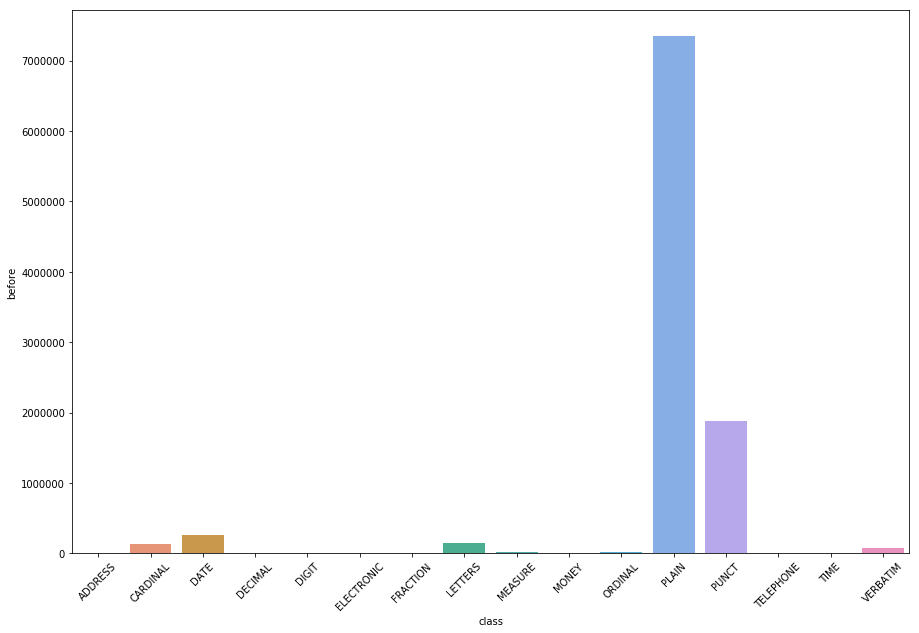

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
hist = df.groupby('class',as_index=False).count()
g= sns.barplot(x=hist['class'],y=hist['before'])
for item in g.get_xticklabels():
    item.set_rotation(45)
plt.show()

In [18]:
# Distribution (%) of classes among the training set
# The two main classes, far above the others, are the Plain and Punct classes
df.groupby('class').count()['before']/df.shape[0]*100

class
ADDRESS        0.005263
CARDINAL       1.348438
DATE           2.604724
DECIMAL        0.099018
DIGIT          0.054867
ELECTRONIC     0.052044
FRACTION       0.012058
LETTERS        1.540464
MEASURE        0.149046
MONEY          0.061784
ORDINAL        0.128075
PLAIN         74.141158
PUNCT         18.959703
TELEPHONE      0.040571
TIME           0.014770
VERBATIM       0.787503
Name: before, dtype: float64

In [21]:
print (( "There are %s different sentences in the training set.") % (len(df['sentence_id'].unique())))

There are 748066 different sentences in the training set.


# Second step: Various machine learning models

# Predicting the class of expressions with XGBoost
In the below, we use a xgboost to complete the task of guessing only the class of the expression, which is a simpler task than guessing the entire spoken form of the expression.

In [4]:
# Preparing the dataset
max_num_features = 20
max_size = 200000
x_data = []
y_data = pd.factorize(df['class'])
labels = y_data[1]
y_data = y_data[0]
for x in df['before'].values:
    x_row = np.zeros(max_num_features, dtype=int)
    #  Taking the ASCII value of an expression, minus that of a
    for xi, i in zip(list(str(x)), np.arange(max_num_features)):
        x_row[i] = ord(xi) - ord('a')
    x_data.append(x_row)
x_data = np.array(x_data[:max_size])
y_data = np.array(y_data[:max_size])

In [7]:
# Training the model
import xgboost as xgb
import numpy as np
import pickle
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split

x_train = x_data
y_train = y_data
del x_data
del y_data
x_train, x_valid, y_train, y_valid= train_test_split(x_train, y_train,
                                                      test_size=0.1, random_state=2017)
num_class = len(labels)

dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(dvalid, 'valid'), (dtrain, 'train')]
param = {'objective':'multi:softmax',
         'eta':'0.3', 'max_depth':10,
         'silent':1, 'nthread':-1,
         'num_class':num_class,
         'eval_metric':'merror'}
model = xgb.train(param, dtrain, 60, watchlist, early_stopping_rounds=20,
                  verbose_eval=10)

[0]	valid-merror:0.0285	train-merror:0.026744
Multiple eval metrics have been passed: 'train-merror' will be used for early stopping.

Will train until train-merror hasn't improved in 20 rounds.
[10]	valid-merror:0.0231	train-merror:0.0209
[20]	valid-merror:0.02215	train-merror:0.019728
[30]	valid-merror:0.0217	train-merror:0.019394
[40]	valid-merror:0.0217	train-merror:0.0192
[50]	valid-merror:0.02175	train-merror:0.018983
[59]	valid-merror:0.02185	train-merror:0.018867


In [8]:
pred = model.predict(dvalid)
pred = [labels[int(x)] for x in pred]
y_valid = [labels[x] for x in y_valid]
x_valid = [ [ chr(x + ord('a')) for x in y] for y in x_valid]
x_valid = [''.join(x) for x in x_valid]
x_valid = [re.sub('a+$', '', x) for x in x_valid]

df_pred = pd.DataFrame(columns=['data', 'predict', 'target'])
df_pred['data'] = x_valid
df_pred['predict'] = pred
df_pred['target'] = y_valid
df_pred.to_csv(os.path.join(out_path, 'pred.csv'))

df_errors = df_pred.loc[df_pred['predict'] != df_pred['target']]
df_errors.to_csv(os.path.join(out_path, 'errors.csv'))

model.save_model(os.path.join(out_path, 'xgb_model'))

# XGBoost using padding of words

In this part, we use the context of an expression, ie its previous words. A padding is defined to let XGBoost understand the boundaries of words.

In [6]:
# Importing necessary packages
import pandas as pd
import numpy as np
import os
import pickle
import gc
import xgboost as xgb
import numpy as np
import re
import pandas as pd
from sklearn.model_selection import train_test_split

max_num_features = 10
pad_size = 1
boundary_letter = -1
space_letter = 0
max_data_size = 320000

df = pd.read_csv('en_train.csv')

x_data = []
y_data =  pd.factorize(df['class'])
labels = y_data[1]
y_data = y_data[0]
gc.collect()
# Similar to the previous approach

88

In [8]:
for x in df['before'].values:
    x_row = np.ones(max_num_features, dtype=int) * space_letter
    for xi, i in zip(list(str(x)), np.arange(max_num_features)):
        x_row[i] = ord(xi)
    x_data.append(x_row)

In [11]:
# Adding context information
def context_window_transform(data, pad_size):
    pre = np.zeros(max_num_features)
    pre = [pre for x in np.arange(pad_size)]
    data = pre + data + pre
    neo_data = []
    for i in np.arange(len(data) - pad_size * 2):
        row = []
        for x in data[i : i + pad_size * 2 + 1]:
            row.append([boundary_letter])
            row.append(x)
        row.append([boundary_letter])
        neo_data.append([int(x) for y in row for x in y])
    return neo_data

x_data = x_data[:max_data_size]
y_data = y_data[:max_data_size]
x_data = np.array(context_window_transform(x_data, pad_size))
gc.collect()
x_data = np.array(x_data)
y_data = np.array(y_data)

print('Total number of samples:', len(x_data))
print('Use: ', max_data_size)
#x_data = np.array(x_data)
#y_data = np.array(y_data)

print('x_data sample:')
print(x_data[0])
print('y_data sample:')
print(y_data[0])
print('labels:')
print(labels)

Total number of samples: 320000
Use:  320000
x_data sample:
[ -1   0   0   0   0   0   0   0   0   0   0  -1  66 114 105 108 108  97
 110 116  97 105  -1 105 115   0   0   0   0   0   0   0   0  -1]
y_data sample:
0
labels:
Index(['PLAIN', 'PUNCT', 'DATE', 'LETTERS', 'CARDINAL', 'VERBATIM', 'DECIMAL',
       'MEASURE', 'MONEY', 'ORDINAL', 'TIME', 'ELECTRONIC', 'DIGIT',
       'FRACTION', 'TELEPHONE', 'ADDRESS'],
      dtype='object')


The above script allowed us to add context to the data via padding. 2 special symbols were used to indicate the boundaries between words.

In [14]:
x_train = x_data
y_train = y_data
gc.collect()

x_train, x_valid, y_train, y_valid= train_test_split(x_train, y_train,
                                                      test_size=0.1, random_state=2017)
gc.collect()
num_class = len(labels)
dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_valid, label=y_valid)
watchlist = [(dvalid, 'valid'), (dtrain, 'train')]

param = {'objective':'multi:softmax',
         'eta':'0.3', 'max_depth':10,
         'silent':1, 'nthread':-1,
         'num_class':num_class,
         'eval_metric':'merror'}
model = xgb.train(param, dtrain, 50, watchlist, early_stopping_rounds=20,
                  verbose_eval=10)
gc.collect()

pred = model.predict(dvalid)
pred = [labels[int(x)] for x in pred]
y_valid = [labels[x] for x in y_valid]
x_valid = [ [ chr(x) for x in y[2 + max_num_features: 2 + max_num_features * 2]] for y in x_valid]
x_valid = [''.join(x) for x in x_valid]
x_valid = [re.sub('a+$', '', x) for x in x_valid]

gc.collect()

df_pred = pd.DataFrame(columns=['data', 'predict', 'target'])
df_pred['data'] = x_valid
df_pred['predict'] = pred
df_pred['target'] = y_valid

[0]	valid-merror:0.007594	train-merror:0.007781
Multiple eval metrics have been passed: 'train-merror' will be used for early stopping.

Will train until train-merror hasn't improved in 20 rounds.
[10]	valid-merror:0.005469	train-merror:0.003535
[20]	valid-merror:0.004938	train-merror:0.002073
[30]	valid-merror:0.00475	train-merror:0.001031
[40]	valid-merror:0.004625	train-merror:0.000493
[49]	valid-merror:0.004656	train-merror:0.000278


# LSTM Model for prediction on the Cardinal class

In [15]:
import numpy as np
from numpy import argmax
import pandas as pd

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.preprocessing.text import text_to_word_sequence

Using TensorFlow backend.


In [16]:
# Max columns for display
pd.options.display.max_columns = 999

# Disable warning message
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("en_train.csv")

In [21]:
def integer_encode_X(X, vocabs, reverse_order=True, max_len=50, pad_default_char=' '):
    char_to_int = dict((c, i) for i, c in enumerate(vocabs))
    
    Xenc = list()
    for pattern in X:
        pattern = pattern[:max_len]
        pattern = pattern + (pad_default_char * (max_len - len(pattern)))
        if reverse_order:
            pattern = pattern[::-1]
        integer_encoded = [char_to_int[char] for char in pattern]
        Xenc.append(integer_encoded)
    return Xenc


def text_to_word_sequence_fixed(text):
    list_words = text_to_word_sequence(text)
    return list_words if len(list_words) > 0 else [text]


def integer_encode_Y(y, vocabs, max_len=50, pad_default_char='PAD'):
    idx_mapping = dict((c, i) for i, c in enumerate(vocabs))
    
    yenc = list()
    for pattern in y:
        pattern = text_to_word_sequence_fixed(pattern)[:max_len]
        pattern = pattern + ([pad_default_char] * (max_len - len(pattern)))
        integer_encoded = [idx_mapping[word] for word in pattern]
        yenc.append(integer_encoded)
    return yenc

def one_hot_encode(X, y, vec_size_x, vec_size_y):
    Xenc = list()
    for seq in X:
        pattern = list()
        for index in seq:
            vector = [0 for _ in range(vec_size_x)]
            vector[index] = 1
            pattern.append(vector)
        Xenc.append(pattern)
    yenc = list()
    for seq in y:
        pattern = list()
        for index in seq:
            vector = [0 for _ in range(vec_size_y)]
            vector[index] = 1
            pattern.append(vector)
        yenc.append(pattern)
    return np.array(Xenc), np.array(yenc)


def invert(seq, vocabs, join_char=''):
    idx_mapping = dict((i, c) for i, c in enumerate(vocabs))

    strings = list()
    for pattern in seq:
        string = idx_mapping[argmax(pattern)]
        strings.append(string)
    return join_char.join(strings)


def make_transform_train_data(
        df, X_vocabs, y_vocabs,
        n_in_seq_length, n_out_seq_length,
        n_in_terms, n_out_terms
    ):
    X_small = df['before']
    y_small = df['after']
    
    x_transformed = integer_encode_X(X_small, X_vocabs, max_len=n_in_seq_length)
    y_transformed = integer_encode_Y(y_small, y_vocabs, max_len=n_out_seq_length)
    
    return one_hot_encode(
        x_transformed,
        y_transformed,
        n_in_terms,
        n_out_terms
    )

# Filtering the data
df_filtered = df[df['class'] == 'CARDINAL']
df_filtered[['before', 'after']] = df_filtered[['before', 'after']].astype(str)

X = df_filtered['before']
y = df_filtered['after']

X_vocabs = set([' '])
for words in X:
    X_vocabs.update(list(words))
X_vocabs = [' '] + [X_vocab for X_vocab in list(X_vocabs) if X_vocab != ' ']

y_vocabs = set()
for words in y:
    y_vocabs.update(text_to_word_sequence_fixed(words))
y_vocabs = ['PAD'] + list(y_vocabs)

n_in_seq_length = np.min([50, len(X_vocabs)])
n_out_seq_length = np.min([50, len(y_vocabs)])

n_in_terms = len(X_vocabs)
n_out_terms = len(y_vocabs)


model = Sequential()
model.add(LSTM(75, input_shape=(n_in_seq_length, n_in_terms)))
model.add(RepeatVector(n_out_seq_length))
model.add(LSTM(50, return_sequences=True))
model.add(TimeDistributed(Dense(n_out_terms, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 75)                30900     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 44, 75)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 44, 50)            25200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 44, 44)            2244      
Total params: 58,344
Trainable params: 58,344
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
x_transformed, y_transformed = make_transform_train_data(
    df_filtered, X_vocabs, y_vocabs,
    n_in_seq_length, n_out_seq_length,
    n_in_terms, n_out_terms
)

model.fit(x_transformed, y_transformed, epochs=1, batch_size=32)

# Get first 2000 rows for verify the model performance
x_transformed_test, y_transformed_test = make_transform_train_data(
    df_filtered.iloc[:2000], X_vocabs, y_vocabs,
    n_in_seq_length, n_out_seq_length,
    n_in_terms, n_out_terms
)

yhat = model.predict(x_transformed_test, verbose=0)

for idx, yh in enumerate(yhat[:50]):
    yh_inverted = invert(yh, vocabs=y_vocabs, join_char=' ').replace(' PAD', '')
    in_seq = invert(x_transformed_test[idx], X_vocabs).replace(' ', '')[::-1]
    out_seq = invert(y_transformed_test[idx], y_vocabs, join_char=' ').replace(' PAD', '')
    print('%s = %s (%s expect: %s)' % (in_seq, yh_inverted, ('TRUE' if out_seq == yh_inverted else "FALSE"), out_seq))    

Epoch 1/1
129568/133744 [============================>.] - ETA: 1028s - loss: 0.1321 - acc: 0.9685